In [1]:
%matplotlib inline

# Q1:  Document Classification
<h2> Q1.1: Reuters Dataset Exploration </h2>
<h3> 1 Turn the code of the Sklearn tutorial above into a notebook  </h3>
It seems that the Passive-agressive algorithm is superior for this task: it provides best accuracy as function of trainning period and #of trainning instances, and it has a relatively low prediction period. 


# Out-of-core classification of text documents


This is an example showing how scikit-learn can be used for classification
using an out-of-core approach: learning from data that doesn't fit into main
memory. We make use of an online classifier, i.e., one that supports the
partial_fit method, that will be fed with batches of examples. To guarantee
that the features space remains the same over time we leverage a
HashingVectorizer that will project each example into the same feature space.
This is especially useful in the case of text classification where new
features (words) may appear in each batch.

The dataset used in this example is Reuters-21578 as provided by the UCI ML
repository. It will be automatically downloaded and uncompressed on first run.

The plot represents the learning curve of the classifier: the evolution
of classification accuracy over the course of the mini-batches. Accuracy is
measured on the first 1000 samples, held out as a validation set.

To limit the memory consumption, we queue examples up to a fixed amount before
feeding them to the learner.



In [2]:
# Authors: Eustache Diemert <eustache@diemert.fr>
#          @FedericoV <https://github.com/FedericoV/>
# License: BSD 3 clause

from __future__ import print_function

from glob import glob
import itertools
import os.path
import re
import tarfile
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves import urllib
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()

Reuters Dataset related routines
--------------------------------




In [3]:
class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urllib.request.urlretrieve(DOWNLOAD_URL, filename=archive_path,
                                   reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

Main
----

Create the vectorizer and limit the number of features to a reasonable
maximum



In [4]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               non_negative=True)


# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
all_classes = np.array([0, 1])
positive_class = 'acq'

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}


def get_minibatch(doc_iter, size, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [(u'{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)


# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batches of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')

Test set is 878 documents (108 positive)
  Passive-Aggressive classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.912 in 1.39s (  692 docs/s)
          Perceptron classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.921 in 1.39s (  689 docs/s)
                 SGD classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.904 in 1.40s (  688 docs/s)
      NB Multinomial classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.877 in 1.43s (  672 docs/s)


  Passive-Aggressive classifier : 	  3911 train docs (   517 positive)    878 test docs (   108 positive) accuracy: 0.938 in 3.87s ( 1011 docs/s)
          Perceptron classifier : 	  3911 train docs (   517 positive)    878 test docs (   108 positive) accuracy: 0.926 in 3.87s ( 1011 docs/s)
                 SGD classifier : 	  3911 train docs (   517 positive)    878 tes

Plot results
------------



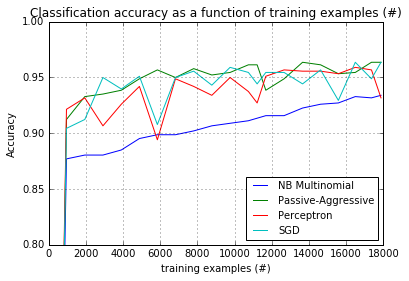

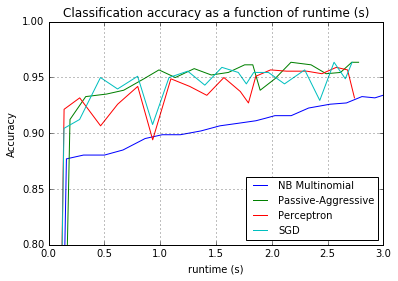

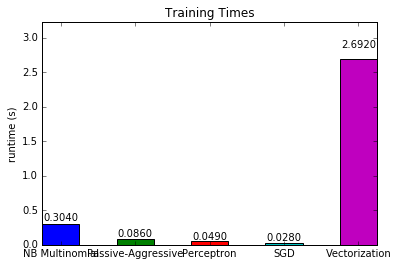

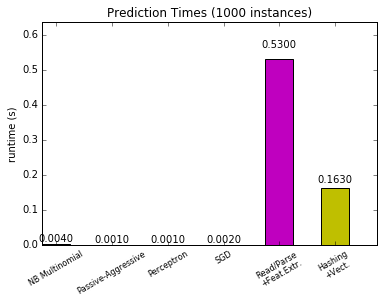

In [5]:
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = []
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['total_fit_time'])

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')

autolabel(rectangles)
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('Hashing\n+Vect.')

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.show()

<h3> 2. Explore how many documents are in the dataset, how many categories, how many documents per categories</h3> 

<br> The number of labeled documents in dataset  19716
<br> The number of categories in dataset  445
<br> Documents per category and statistics

<img src="docPerCategory.png">

In [6]:
# Reuters-21578 dataset downloader and parser
#
# Author:  Eustache Diemert <eustache@diemert.fr> 
# http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html
#
# Modified by @herrfz, get pandas DataFrame from the orig SGML
# License: BSD 3 clause

from __future__ import print_function

import re
import os.path
import fnmatch
import sgmllib
import urllib
import tarfile
import itertools
from pandas import DataFrame

###############################################################################
# Reuters Dataset related routines
###############################################################################


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()


class ReutersParser(sgmllib.SGMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""
    def __init__(self, verbose=0):
        sgmllib.SGMLParser.__init__(self, verbose)
        self._reset()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk)
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


class ReutersStreamReader():

    """Iterate over documents of the Reuters dataset.
    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.
    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.
    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    def __init__(self, data_path):
        self.data_path = data_path
        if not os.path.exists(self.data_path):
            self.download_dataset()

    def download_dataset(self):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              self.data_path)
        os.mkdir(self.data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')
        urllib.urlretrieve(self.DOWNLOAD_URL,
                           filename=os.path.join(self.data_path,
                                                 self.ARCHIVE_FILENAME),
                           reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untaring data ...")
        tfile = tarfile.open(os.path.join(self.data_path,
                                          self.ARCHIVE_FILENAME),
                             'r:gz')
        tfile.extractall(self.data_path)
        print("done !")

    def iterdocs(self):
        """Iterate doc by doc, yield a dict."""
        for root, _dirnames, filenames in os.walk(self.data_path):
            for filename in fnmatch.filter(filenames, '*.sgm'):
                path = os.path.join(root, filename)
                parser = ReutersParser()
                for doc in parser.parse(open(path)):
                    yield doc


def get_minibatch(doc_iter, size):
    """Extract a minibatch of examples, return a tuple X, y.
    Note: size is before excluding invalid docs with no topics assigned.
    """
    data = [('{title}\n\n{body}'.format(**doc), doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return DataFrame([])
    else:
        return DataFrame(data, columns=['text', 'tags'])


In [7]:
import pandas as pd
import numpy as np

#data_streamer = ReutersStreamReader('reuters').iterdocs()
#y = len(list(data_streamer))
#print(y)

data_streamer = ReutersStreamReader('reuters').iterdocs()
data = get_minibatch(data_streamer, None)
print("number of labeled documents in dataset ",data.count()[0])

#type(data)


number of labeled documents in dataset  19716


In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit_transform(data['tags'])
print("number of categories in dataset ",len(mlb.classes_))

#data[0:10]
#print(mlb.classes_)

number of categories in dataset  445


In [9]:
x = mlb.fit_transform(data['tags'])
df = pd.DataFrame(data=x[1:,0:], columns=mlb.classes_[:])
df.describe()

,acq,adb-africa,adb-asia,afghanistan,alfonsin,algeria,alum,amex,andriessen,angola,...,yen,yeutter,young,yugoslavia,zaire,zambia,zhao-ziyang,zimbabwe,zinc,zse
count,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,...,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000,19715.000000
mean,0.124169,0.000507,0.001014,0.000152,0.000101,0.001775,0.003196,0.003043,0.000051,0.000101,...,0.003500,0.003196,0.000051,0.002384,0.000457,0.001167,0.000406,0.000812,0.002232,0.000203
std,0.329783,0.022517,0.031835,0.012335,0.010072,0.042098,0.056440,0.055084,0.007122,0.010072,...,0.059058,0.056440,0.007122,0.048769,0.021362,0.034137,0.020140,0.028477,0.047190,0.014243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h3> 3. Explore how many characters and words are present in the documents of the dataset </h3>
<br> number of characters in labelled documents:  10482226
<br> number of words in labelled documents:  1701696
<br> number of different words in labelled docs  71911

The code below counts the above

In [16]:
import nltk
from nltk.corpus import stopwords
import sys

def cleanupDoc(s):
     stopset = set(stopwords.words('english'))
     tokens = nltk.word_tokenize(s)
     cleanup = [token.lower() for token in tokens if token.lower() not in stopset and  len(token)>2]
     return cleanup

In [29]:
wordcount={}
no_of_words = 0
no_of_chars = 0
step = 0
total = len(data['text'])
increment = total//40

for x in data['text']:
    if((step % increment) == 0):
        sys.stdout.write(".")
        sys.stdout.flush()
    #s = "I am going to disco and bar tonight"
    step += 1
    tokens = cleanupDoc(x)
    for token in tokens:
        if token not in wordcount:
            wordcount[token] = 1
            no_of_words +=1
            no_of_chars += len(token)
        else:
            wordcount[token] += 1
            no_of_words +=1
            no_of_chars += len(token)
    

print("\n")
print("number of characters in labelled documents: ",no_of_chars)
print("number of words in labelled documents: ",no_of_words)
print("number of different words in labelled docs ",len(wordcount))    

.........................................

number of characters in labelled documents:  10482226
number of words in labelled documents:  1701696
number of different words in labelled docs  71911


<h3> 4. Explain informally what are the classifiers that support the "partial-fit" method discussed in the code </h3>

The classifiers that support the "partial-fit" method discussed in the code are: Storchastic gradient descent, Multi layer perceptron, Naive Bayes and Passive Agressive. 

Stoachastic gradient descent
Multi layer perceptron 
Naive Bayes 

With this classifiers the loss function is updated after every train instance or a batch of instances, and doesn't require all the instances to calculate the iteration loss function. 

<b> Multi layer perceptron </b> - the weights are updated after presenting each batch of trainning instances based on the loss function. 
<br> <b> Stochastic gradient descent</b> - the model weights\parameters are updated for each training instance in the direction of the gradient. 
<br> <b> Naive Bayes</b> - The probability that an instance belong to a specific class, equals to the probability of the class and the conditional probability of the likelihood to get the instance features with a specific class. Calculating of these probabilities is based on advanced counting of trainning instances. One can update counters of trainning instances per class, and trainning instances features per class. The counters are updated per intances, so there is no need to load all the instances into memory. 
<br><b> Passive agressive </b>- Intuitively, once the specific train instance is classified correctly there is no change to the model, while it is classified incorrectly the model is adjusted to provide the correct classification. 


<h3> 5. Explain what is the hashing vectorizer used in this tutorial. Why is it important to use this vectorizer to achieve "streaming classification"? </h3>

The hashing vectorizer used in this tutorial converts a collection of text documents to a matrix of token occurrences. It is used in order to convert each documents into a one hot vector of the words which appear in this document. It is import to use this vectorizer to achieve "streaming classification" since it can generate the list of all words included in all document in a streaming mode, so it doesn't require that all documents will be stored in memory. 

<h1> Q2 Sequence Labelling for Named Entity Recognition </h1>
<h2> Named Entity Recognition (NER) </h2>

In [1]:
from nltk.corpus import conll2002
from itertools import chain
import nltk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
#import pycrfsuite


etr = conll2002.chunked_sents('esp.train') # In Spanish
eta = conll2002.chunked_sents('esp.testa') # In Spanish
etb = conll2002.chunked_sents('esp.testb') # In Spanish

In [2]:
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
test_sentsa = list(nltk.corpus.conll2002.iob_sents('esp.testa'))


In [3]:
print(train_sents[0])

[(u'Melbourne', u'NP', u'B-LOC'), (u'(', u'Fpa', u'O'), (u'Australia', u'NP', u'B-LOC'), (u')', u'Fpt', u'O'), (u',', u'Fc', u'O'), (u'25', u'Z', u'O'), (u'may', u'NC', u'O'), (u'(', u'Fpa', u'O'), (u'EFE', u'NC', u'B-ORG'), (u')', u'Fpt', u'O'), (u'.', u'Fp', u'O')]


Translate words to features

In [4]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
        'word_lower':word.lower(),
        'suffix3':word[-3:],
        'suffix2':word[-2:],
        'prefix1':word[:2],
        'prefix2':word[:3],
        'wordIsupper':word.isupper(),
        'wordIstitle':word.istitle(),
        'word.isdigit':word.isdigit(),
        'postag':postag,
#        'postag[:2]=' + postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1word.lower': word1.lower(),
            '-1word.istitle': word1.istitle(),
            '-1word.isupper': word1.isupper(),
            '-1word.isdigit':word1.isdigit(),
            '-1postag' :postag1,
#            '-1postag[:2]=' + postag1[:2],
        })
    else:
        #features.update('BOS')
        word1 = 'bos'
        postag1 = 'bos'
        features.update({
            '-1word.lower': word1.lower(),
            '-1word.istitle': word1.istitle(),
            '-1word.isupper': word1.isupper(),
            '-1postag' :postag1,
#            '-1postag[:2]=' + postag1[:2],
        })
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '1word.lower': word1.lower(),
            '1word.istitle': word1.istitle(),
            '1word.isupper': word1.isupper(),
            '1postag' :postag1,
#            '-1postag[:2]=' + postag1[:2],
        })
    else:
        #features.update('BOS')
        word1 = 'eos'
        postag1 = 'eos'
        features.update({
            '1word.lower': word1.lower(),
            '1word.istitle': word1.istitle(),
            '1word.isupper': word1.isupper(),
            '1postag' :postag1,
#            '-1postag[:2]=' + postag1[:2],
        })

                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]    

In [5]:
%%time

X_train = []
for s in train_sents:
    X_train.extend(sent2features(s))
    
y_train = []
for s in train_sents:
    y_train.extend(sent2labels(s))


Wall time: 977 ms


In [6]:
X_test = []
for s in test_sents:
    X_test.extend(sent2features(s))
    
y_test = []
for s in test_sents:
    y_test.extend(sent2labels(s))

Encode train data set

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

v = DictVectorizer()
X = v.fit_transform(X_train)
Xt = v.transform(X_test)

Train and test the model

<img src = "nerprecision.png">

In [12]:
y_predict = trainer.predict(Xt)

In [13]:
print(classification_report(y_test,y_predict))

             precision    recall  f1-score   support

      B-LOC       0.75      0.75      0.75      1084
     B-MISC       0.54      0.45      0.49       339
      B-ORG       0.79      0.83      0.81      1400
      B-PER       0.85      0.89      0.87       735
      I-LOC       0.69      0.43      0.53       325
     I-MISC       0.59      0.33      0.42       557
      I-ORG       0.70      0.62      0.66      1104
      I-PER       0.84      0.91      0.87       634
          O       0.99      1.00      0.99     45355

avg / total       0.96      0.96      0.96     51533



In [14]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predict,labels=["B-LOC","B-MISC","B-ORG","B-PER","I-LOC","I-MISC","I-ORG","I-PER","O"]))

# cm = confusion_matrix(y_test, y_predict)
# pl.matshow(cm)
# pl.title('Confusion matrix of the classifier')
# pl.colorbar()
# pl.show()

[[  810     6   124    35    17     8    37     3    44]
 [   18   153    58     9     1    13    20     2    65]
 [   97    21  1169    47     2     8    29     1    26]
 [   32     4    21   656     1     3     4     5     9]
 [   29     5     9     4   141     9    56    33    39]
 [   18    24    22     1    13   183    98    13   185]
 [   69    51    48     5    18    62   684    54   113]
 [    7     2     2     7     5     3    20   578    10]
 [    6    18    19     4     6    20    24     1 45257]]


<h2> Q2.2 HMM and Viterbi</h2>

In [15]:
import sys
from collections import defaultdict
import math

"""
Count n-gram frequencies in a CoNLL NER data file and write counts to
stdout. 
"""

def simple_conll_corpus_iterator():
    """
    Get an iterator object over the corpus file. The elements of the
    iterator contain (word, ne_tag) tuples. Blank lines, indicating
    sentence boundaries return (None, None).
    """
    
    for line in train_sents:
        if line: # Nonempty line
            # Extract information from line.
            # Each line has the format
            # word pos_tag phrase_tag ne_tag
            for i in range(len(line)):
                word = line[i][0]
                ne_tag = line[i][2]
                #print(word,ne_tag)
                yield word, ne_tag
        else: # Empty line
            yield (None, None)                        
      
    
def sentence_iterator(corpus_iterator):
    """
    Return an iterator object that yields one sentence at a time.
    Sentences are represented as lists of (word, ne_tag) tuples.
    """  
    
    current_sentence = [] #Buffer for the current sentence
    for l in corpus_iterator:        
            if l==(None, None):
                if current_sentence:  #Reached the end of a sentence
                    yield current_sentence
                    current_sentence = [] #Reset buffer
                else: # Got empty input stream
                    sys.stderr.write("WARNING: Got empty input file/stream.\n")
                    raise StopIteration
            else:
                current_sentence.append(l) #Add token to the buffer

    if current_sentence: # If the last line was blank, we're done
        yield current_sentence  #Otherwise when there is no more token
                                # in the stream return the last sentence.

def get_ngrams(sent_iterator, n):
    """
    Get a generator that returns n-grams over the entire corpus,
    respecting sentence boundaries and inserting boundary tokens.
    Sent_iterator is a generator object whose elements are lists
    of tokens.
    """
          
    for sent in sent_iterator:
         #Add boundary symbols to the sentence
         w_boundary = (n-1) * [(None, "*")]
         w_boundary.extend(sent)
         w_boundary.append((None, "STOP"))
         #Then extract n-grams
         ngrams = (tuple(w_boundary[i:i+n]) for i in xrange(len(w_boundary)-n+1))
         for n_gram in ngrams: #Return one n-gram at a time
            yield n_gram        




In [16]:
class Hmm(object):
    """
    Stores counts for n-grams and emissions. 
    """

    def __init__(self, n=3):
        assert n>=2, "Expecting n>=2."
        self.n = n
        self.emission_counts = defaultdict(int)
        self.ngram_counts = [defaultdict(int) for i in xrange(self.n)]
        self.all_states = set()
        self.count_y = dict() 
        #[('O', 0), ('I-MISC', 0), ('I-PER', 0), ('I-ORG', 0), ('I-LOC', 0), ('B-MISC', 0), ('B-PER', 0), ('B-ORG', 0), ('B-LOC', 0)])
        self.count_xy = dict()
        self.trigram_counts = dict()
        self.bigram_counts = dict()
        

    def train(self):
        """
        Count n-gram frequencies and emission probabilities from a corpus file.
        """
        ngram_iterator = \
            get_ngrams(sentence_iterator(simple_conll_corpus_iterator()), self.n)

        for ngram in ngram_iterator:
            #Sanity check: n-gram we get from the corpus stream needs to have the right length
            assert len(ngram) == self.n, "ngram in stream is %i, expected %i" % (len(ngram, self.n))

            tagsonly = tuple([ne_tag for word, ne_tag in ngram]) #retrieve only the tags            
            for i in xrange(2, self.n+1): #Count NE-tag 2-grams..n-grams
                self.ngram_counts[i-1][tagsonly[-i:]] += 1
            
            if ngram[-1][0] is not None: # If this is not the last word in a sentence
                self.ngram_counts[0][tagsonly[-1:]] += 1 # count 1-gram
                self.emission_counts[ngram[-1]] += 1 # and emission frequencies

            # Need to count a single n-1-gram of sentence start symbols per sentence
            if ngram[-2][0] is None: # this is the first n-gram in a sentence
                self.ngram_counts[self.n - 2][tuple((self.n - 1) * ["*"])] += 1
    
    def calc_count_xy_y(self):
        
        for word, ne_tag in self.emission_counts:
            count = self.emission_counts[(word,ne_tag)]
            label = ne_tag
            if label in self.count_y:
                self.count_y[label] = self.count_y[label]+int(float(count))
            else:
                self.count_y.update({label:count})

            if word in self.count_xy:
                self.count_xy[word].update({label : count})
            else:
                self.count_xy[word] = {label : count}

    def calc_transition_count(self,printngrams=[1,2,3]):
        
        for n in printngrams:            
                for ngram in self.ngram_counts[n-1]:
                    count = self.ngram_counts[n-1][ngram]
                    ngramstr = " ".join(ngram)
                    if (n == 2):
                        self.bigram_counts[ngramstr] = count
                    elif (n == 3):
                        self.trigram_counts[ngramstr] = count
                            



In [17]:
#counter.emission_counts - count per word,ne_tag
#counter.ngram_counts - count per ne_tag, ne_tag, ne_tag
# Initialize a trigram counter
counter = Hmm(3)
# Collect counts
counter.train()
# calc e
## should replace with Lidstone estimator
counter.calc_count_xy_y()
# calc q
counter.calc_transition_count()

Calculate Viterbi

<img src = "viterbi.png">

In [20]:
import sys
from collections import defaultdict
import math
import logging

#import emission_counts
#import transition_counts

"""
Usage:
python viterbi.py ner.counts ngram.counts ner_dev.dat > [output_file]
Implementation of the Viterbi algorithm
Calculate emission e(x|y) and trigram probability based on data 
in ner_counts,
Read ner_dev.dat, output prediction to [output_file]
"""


# Go through dev data, predict tag & compute probability based on model abov
log_probability = 0
y_predict = []
y_actual = []
# First round for q(*, *, y_1)
first_round = True
for sent in test_sents:
    log_probability = 0
    first_round = True
    for i in  range(len(sent)):
        word = sent[i][0]
        # Check if there is an existing label associated to the word
        if word in counter.count_xy:
            max_probability = 0
            for label in list(counter.count_xy[word]):
                # Calculate e(x|y)
                emission = float(counter.count_xy[word][label]) / float(counter.count_y[label])
                # Calculate q(y| y_i-2, y_i-1)
                # Check for first round
                if first_round:
                    y_2 = '*'
                    y_1 = '*' 
                    first_round = False
                bigram = y_2 + ' ' + y_1
                trigram = y_2 + ' ' + y_1 + ' ' + label
                parameter = 0.0000000001
                if trigram in counter.trigram_counts:
                    parameter = float(counter.trigram_counts[trigram])/float(counter.bigram_counts[bigram])
                probability = parameter*emission
                if probability > max_probability:
                    max_probability = probability
                    arg_max = label	
        
            log_probability = log_probability + math.log(max_probability)
            y_actual.append(sent[i][2])
            y_predict.append(arg_max)
            y_2 = y_1
            y_1 = arg_max
        else:
            y_predict.append('O')
            y_actual.append(sent[i][2])
            

#     # If Count(x~>y) = 0, use _RARE_ 
#     else:
#         for label in list(count_xy['_RARE_']):
#             # Calculate e(_RARE_|y)
#             probability = 0
#             emission = float(count_xy['_RARE_'][label]) / float(count_y[label])
#             # Calculate q(y| y_i-2, y_i-1)
#             # Check for first round
#             if first_round:
#                 y_2 = '*'
#                 y_1 = '*' 
#                 first_round = False
#             bigram = y_2 + ' ' + y_1
#             trigram = y_2 + ' ' + y_1 + ' ' + label
#             parameter = 0.0000000001
#             if trigram in trigram_counts:
#                 parameter = float(trigram_counts[trigram])/float(bigram_counts[bigram])
#             probability = parameter*emission
#             if probability > max_probability:
#                 max_probability = probability
#                 arg_max = label

Evaluate results 

In [21]:
print(classification_report(y_actual,y_predict))

             precision    recall  f1-score   support

      B-LOC       0.50      0.69      0.58      1084
     B-MISC       0.51      0.47      0.49       339
      B-ORG       0.85      0.77      0.81      1400
      B-PER       0.81      0.60      0.69       735
      I-LOC       0.61      0.30      0.40       325
     I-MISC       0.51      0.30      0.38       557
      I-ORG       0.75      0.57      0.65      1104
      I-PER       0.84      0.50      0.63       634
          O       0.96      0.98      0.97     45355

avg / total       0.93      0.94      0.93     51533



<h2> Q2.3 Using Word Embeddings </h2>

Unforutunately, the code for this question doesn't function yet. It is just a pseudo code.

In [70]:
import gensim, logging

model_path = 'GoogleNews-vectors-negative300.bin'
model = gensim.models.Word2Vec.load_word2vec_format(model_path, binary=True)

In [74]:
model.similarity('woman', 'man')
vector = model['woman']

Add word embedding features to origianl features

In [180]:
import numpy as np

def word2embedding(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
            
    if word in model.vocab:
        worde = word
    else:
        worde = 'null'
    
    res = model[worde]
     
    if i > 0:
        word1 = sent[i-1][0]
        if word1 in model.vocab:
            worde = word1
        else:
            worde = 'null'
    
        res.extend(model[worde])
    
    else:
        res.extend(model['null'])
  
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        if word1 in model.vocab:
            worde = word1
        else:
            worde = 'null'
        res.extend(model[worde])
    
    else:
        res.extend(model['null'])
    
    res.shape = (1,900)
    return res
        
def sent2embedding(sent):
        rese = []
        for  i in range(len(sent)):
            line = word2embedding(sent,i)
            rese.append(line)
        
        resee = np.vstack(rese)
                #rese.extend(word2embedding(sent, i))
        #print(resee.shape)
        return resee

Concatanate original feature matrix with word embedding matrix

In [182]:
Xe = []
for s in train_sents:
        mat = sent2embedding(s)
        Xe.append(mat)
Xee = np.vstack(Xe)
finalX = np.concatanate(X,Xee)


Xet = []
for s in test_sents:
        mat = sent2embedding(s)
        Xet.append(mat)
Xeet = np.vstack(Xet)
finalXt = np.concatanate(Xt,Xeet)

AttributeError: 'module' object has no attribute 'concatanate'

Train and test model

In [ ]:
from sklearn.linear_model import LogisticRegression

trainere = LogisticRegression(multi_class='multinomial',solver='newton-cg')
trainere.fit(finalX,y_train)


In [82]:
y_predictE = trainer.predict(finalXt)

In [82]:
print(classification_report(y_actual,y_predictE))